<img src="images/logo/selene-logo-640.png" style="max-height:75px;" alt="SELENE Logo" />

**Disclaimer:** This Jupyter Notebook contains content generated with the assistance of AI. While every effort has been made to review and validate the outputs, users should independently verify critical information before relying on it. The SELENE notebook repository is constantly evolving. We recommend downloading or pulling the latest version of this notebook from Github.

# Decision Trees &mdash; CART (Classification and Regression Trees)

The Classification and Regression Trees (CART) algorithm was introduced by Breiman, Friedman, Olshen, and Stone in 1984, and it is one of the most influential methods for building decision trees in machine learning. Like most other decision tree learning algorithms, CART recursively partitions the feature space into regions that are as homogeneous as possible with respect to the target variable. What makes CART unique is its use of binary splits and impurity reduction as a unifying principle for both classification and regression. While some earlier algorithms, such as ID3, focused only on classification with categorical features, CART was designed from the start to handle both discrete and continuous variables, making it more versatile. Its greedy approach &mdash; evaluating all possible features and split points to choose the best one at each step &mdash; ensures that the tree can adapt to the structure of the data, even if the true relationship between variables is complex and nonlinear.

In practice, CART is highly relevant because it is not only a powerful standalone model but also the foundation of many modern ensemble methods, such as **Random Forests** and **Gradient Boosted Trees**. These ensemble methods have become state-of-the-art for tabular data tasks across industries, from finance and healthcare to recommendation systems and fraud detection. Without CART, these widely used techniques would not exist in their current form. Its influence extends beyond tree-based ensembles, since the ideas of recursive partitioning and greedy search for splits remain central in machine learning.

Learning about CART is important for two reasons. First, it provides a clear and intuitive understanding of how decision trees work, which makes it easier to interpret more complex algorithms that build on them. Decision trees are also among the most interpretable machine learning models, making them invaluable in contexts where transparency and explainability are required. Second, studying CART helps practitioners appreciate the trade-offs between interpretability, computational efficiency, and predictive power. This understanding is essential when deciding whether to use a simple tree, an ensemble, or alternative models for a given problem. So let's dive in and see how the algorithms works.

### Setting up the Notebook

#### Make Required Imports

This notebook requires the import of different Python packages but also additional Python modules that are part of the repository. If a package is missing, use your preferred package manager (e.g., [conda](https://anaconda.org/anaconda/conda) or [pip](https://pypi.org/project/pip/)) to install it. If the code cell below runs with any errors, all required packages and modules have successfully been imported.

In [1]:
from src.utils.libimports.cart import *
from src.utils.plotting.cart import *
from src.utils.data.files import *
from src.models.trees.cart import *

#### Download Required Data

Some code examples in this notebook use data that first need to be downloaded by running the code cell below. If this code cell throws any error, please check the configuration file `config.yaml` if the URL for downloading datasets is up to date and matches the one on Github. If not, simply download or pull the latest version from Github.

In [2]:
bank_data ,_ = download_dataset("tabular/classification/example-credit-default-data.csv")
cart_data ,_ = download_dataset("tabular/classification/example-data-cart-overfitting-underfitting.csv")

File 'data/datasets/tabular/classification/example-credit-default-data.csv' already exists (use 'overwrite=True' to overwrite it).
File 'data/datasets/tabular/classification/example-data-cart-overfitting-underfitting.csv' already exists (use 'overwrite=True' to overwrite it).


---

## Quick Recap: Decision Trees

Let's consider the same toy example scenario we used in the notebooks introducing Decision Trees. In this scenario, a bank has a dataset of customers' information and whether they defaulted on their credit or not. Using this data, the bank wants to train some classification model to predict if future customers will likely default on their credit &mdash; and therefore potentially reject a credit application. Each customer described by four attributes: *Age*, *Education* (Bachelor, Masters, or PhD), *Martial_Status* (Single or Married), and *Annual_Income*. The attribute *Credit_Default* (Yes or No) indicates if the customer defaulted on their credit or not. To keep it simple but also work with a complete dataset, this toy dataset contains only 9 customers. Let's load the data from the file into a pandas DataFrame and have a look:

In [3]:
df_bank = pd.read_csv(bank_data)

df_bank.head(10)

,ID,Age,Education,Marital_Status,Annual_Income,Credit_Default
0,1,23,Masters,Single,75000,NO
1,2,35,Bachelor,Married,50000,YES
2,3,26,Masters,Single,70000,NO
3,4,41,PhD,Single,95000,NO
4,5,18,Bachelor,Single,40000,YES
5,6,55,Masters,Married,85000,YES
6,7,30,Bachelor,Single,60000,YES
7,8,35,PhD,Married,60000,NO
8,9,28,PhD,Married,60000,NO


Let's also extract each feature as an array of values since we will be using those later.

In [4]:
ages = df_bank.Age.to_numpy()
educations = df_bank.Education.to_numpy()
incomes = df_bank.Annual_Income.to_numpy()
mstatuses = df_bank.Marital_Status.to_numpy()
targets = df_bank.Credit_Default.to_numpy()

The basic intuition behind Decision Trees is that they split data into increasingly homogeneous groups by asking a series of simple questions. At each step, the algorithm chooses a feature and a threshold (for numeric data) or a grouping (for categorical data) that best separates the data according to some impurity measure &mdash; depending on the task (classification or regression) and chosen decision Tree learning algorithm (here: CART). Each split creates a branch in the tree, leading to subsets of the data that are more uniform with respect to the target variable. This process continues recursively until the subsets are sufficiently "pure" or other stopping conditions are met. The result is a tree-like structure where following the branches from the root to a leaf corresponds to applying a sequence of if-then rules.

The figure below shows a possible Decision Trees for our toy dataset. The **internal nodes** (blue boxes) contain the condition that is checked to choose the branch to follow. For example, the root node asks the Yes/No question *"Is the marital status 'single'?"*. If the answer is, say, *"Yes/True"*, we follow the left branch, checking the condition of the child node and so on. The **leaf nodes** (green boxes) represents the end point of a decision path, where no further splitting occurs. It contains the final output or prediction for the data that reaches it. For classification tasks, a leaf node typically holds the most common class label, and for regression tasks, it stores the average or mean value of the target variable.

<img src="images/illustrations/decision-trees/dt-banking-example-01.png" style="margin:auto;" alt="Decision Tree for Banking Example">

To see how this The Decision Tree matches our toy dataset, let's go through some example using the last data sample *(28, "PhD", "Married", 6000)*. According to the tree, we first need to check if the marital status is *"Single"*. Since this is false, we follow the right branch and now need to check if the education is "PhD". This is true, so we follow the left branch, reaching a leaf node with the target label "NO". This indeed matches the value for the target variable in the dataset. You can try the same process for all 9 samples in our toy dataset. It will work for all of them.

We also saw in the introductory notebook about Decision Trees, that there is generally not just one tree that matches a training dataset. For example, the Decision Tree in the figure below is equivalent to the previous one in the sense that it also perfectly matches the toy dataset &mdash; again, if in doubt, you can convince yourself by checking all 9 data samples again.

<img src="images/illustrations/decision-trees/dt-banking-example-02.png" style="margin:auto;" alt="Decision Tree for Banking Example">

<br />

The important observation here is that different Decision Trees for the same dataset may also "behave" differently. On the one hand, the second tree is arguably smaller and is therefore faster to train and will also make faster predictions (i.e., better efficiency). More importantly, both trees may yield different predictions for the same unseen data sample. For example, consider the data sample *(50, "PhD", "Single", 70000)*. Using the first Decision Tree and following the branch from the root to the leaf will return a *"NO"*. The second Decision Tree, in contrast, will return a *"YES"*. Again, you are encouraged to check for yourself by tracing the corresponding branches in both trees.

Strictly speaking, the "optimal" tree is the one that performs best on an arbitrary large unseen dataset. However, finding the optimal Decision Tree is **NP-hard** because the search space of all possible trees grows exponentially with the number of features and samples. At each node, the algorithm must decide both which feature to split on and where to place the split threshold. Since these choices compound recursively at every node, the number of possible tree structures quickly becomes astronomically large. Determining the optimal tree (e.g., the smallest tree with minimum misclassification error) would require exhaustively searching through this combinatorial space. It has been shown that constructing a minimum-size decision tree consistent with training data is equivalent to solving certain known *NP*-complete problems. This means there is no known polynomial-time algorithm to guarantee finding the globally optimal tree &mdash; well, unless *P = NP*. Practical algorithms therefore use **greedy heuristics**, splitting on the locally best feature at each node, which produces good &mdash; but not provably optimal &mdash; trees within reasonable computation time. Different learning algorithms may therefore yield different Decision Trees, and in this notebook, we look at the very popular CART algorithm.

If anything is unclear up to this point, we recommend having another look at the introductory notebook about Decision Trees.

---

## Original CART Algorithm

In this notebook, we distinguish between the CART algorithm as proposed by Breiman, Friedman, Olshen, and Stone in 1984, and practical implementation of the algorithm. The original algorithm provides a mathematically elegant and conceptually simple framework for learning decision trees. The original description focuses on the core principles: recursive binary splitting based on impurity measures, full tree growth followed by cost-complexity pruning, and well-defined statistical foundations. It assumes idealized conditions, such as complete data and exhaustive evaluation of all possible splits, in order to present a clear and rigorous formulation of the method.

In practice, however, datasets are messy, high-dimensional, and often incomplete, which makes directly applying the theoretical algorithm inefficient or impractical. Real-world implementations introduce adaptations &mdash; such as handling missing values, adding early stopping rules, and optimizing split searches &mdash; that deviate from the pristine, textbook description but make the method scalable and robust. Thus, the original version of the algorithm serves as the foundational blueprint, while practical versions are engineered extensions designed to meet the complexities of applied machine learning. We will cover such practical applications in later sections.

In the following, let's first focus on the original CART algorithm. The core part of CART is to find the best split for a current internal node, starting at the root node &mdash; this holds true for other Decision Tree learning algorithms, and this is where other algorithms mostly differ. We can split the task of finding the best split into two substask: (1) Enumerating all possible splits we want to consider, and (2) scoring all possible splits to find the best one. Again, different learning algorithms implement both steps differently, so let's see how CART is doing them and actually provide a simple implementation from scratch for the core parts.

### Enumerating all Possible Splits

One of the key characteristics of the CART algorithm is that it considers only binary splits. This makes trees simpler, more interpretable, and computationally efficient. Each decision is reduced to a Yes/No question &mdash; e.g., "feature $\leq$ threshold?" for ordinal/numerical values or "feature $\in$ category?" for nominal values &mdash; which is easy to understand and visualize. Binary splits also streamline the optimization process, since the algorithm only needs to search for one threshold at a time, rather than evaluating all possible multi-way partitions. Despite this restriction, binary splits do not reduce the expressive power of the model, since any multi-way split can be represented as a sequence of binary ones. This approach provides a consistent framework for handling both continuous and categorical features while ensuring that the resulting trees remain flexible and capable of capturing complex decision boundaries.

When enumerating all possible splits, we need to consider the type of features. Since "feature $\leq$ threshold?" questions assume some meaningful partial ordering, we consider ordinal, interval, and ratio features together as non-nominal features. In contrast, nominal features values do not allow for meaningful "is less than equal" comparisons. Thus, we need to handle nominal features separately to reflect "feature $\in$ category?" questions. Let's start with non-nominal features.

#### Non-Nominal Features

The CART algorithm (and many other Decision Tree algorithms) does not require full arithmetic comparison but solely relies on comparing feature values. In case of non-nominal features (ordinal, interval, ratio) this comes down to *"feature $\leq$ threshold?"* comparisons. Note that we can always convert ordinal string values into ordinal integer values and preserve the partial order during this conversation. Again, since CART only relies on comparisons, the exact integer values do not matter (as long as the partial order is preserved).

The **candidate thresholds** for splitting a non-nominal feature are determined directly from the training data. Specifically, the feature values are first sorted, and the algorithm considers potential thresholds only at the **midpoints between consecutive distinct values**. For example, if the unique and sorted values of a feature are $[x_1, x_2, \dots, x_n]$, with $x_i < x_{i+1}$, then each candidate threshold $t$ is chosen as

$$\large
t = \frac{x_i + x_{i+1}}{2}
$$

This ensures that no training sample lies exactly on the threshold while still covering all distinct ways the data can be split. For an example, the figure below shows all unique values for feature "Age" (black dots) plotted onto a coordinate line, and the midpoints as the candidate thresholds added as blue dashed lines (incl. the actual threshold value). Note that we have with $35$ one duplicate values, resulting in 8 unique values and therefore 7 midpoints/thresholds.

<img src="images/illustrations/decision-trees/dt-cart-nonnominal-thresholds-example.png" style="margin:auto;max-width:600px;width:100%" alt="CART Algorithm - Thresholds Example">

<br />

Let's actually implement the computation of all candidate thresholds in Python. The method `compute_thresholds()` in the code cell below takes in a list of numerical values for a single feature &mdash; recall that we assume that ordinal string values have been converted into numerical values. First we use the NumPy method [`np.unique()`](https://numpy.org/doc/stable/reference/generated/numpy.unique.html) methods to identify all unique values (in case of duplicates). Conveniently, this method returns all unique values as a sorted array. The last line of the method simply implements just the formula above, but for all midpoints in parallel. This avoids any loop and generally performs much faster.

In [5]:
def compute_thresholds(feature_values):
    # Get unique values to handle duplicates; return values will already be sorted
    values_sorted = np.unique(feature_values)
    # Compute and return all midpoints between consective values
    return (values_sorted[:-1] + values_sorted[1:]) / 2.0

Let's run this method for the two numerical features "Age" and "Annual_Income"; the results for "Age" naturally reflect the figure above.

In [6]:
print(f"Candidate thresholds for feature 'Age':            {compute_thresholds(ages)}")
print(f"Candidate thresholds for feature 'Annual_Income':  {compute_thresholds(incomes)}")

Candidate thresholds for feature 'Age':            [20.5 24.5 27.  29.  32.5 38.  48. ]
Candidate thresholds for feature 'Annual_Income':  [45000. 55000. 65000. 72500. 80000. 90000.]


Now that we can compute all candidate thresholds, we only need another method to compute the actual split for a given threshold. This is very easy to do since all we need to do is to compare all feature values with the given threshold to see if a data sample should follow the left branch and the right branch. To this end, the method `generate_split_general()` in the code cell below used the method [`[np.where]`](numpy.org/doc/stable/reference/generated/numpy.where.html) to find all the indices in the array of the feature values which are less than equal and greater than the threshold. Note that each binary split is represented by these to list of indices. This makes it very easy to later extract the corresponding data samples.

In [7]:
def generate_split_general(feature_values, threshold):
    indices_left  = np.where(feature_values <= threshold)[0]
    indices_right = np.where(feature_values > threshold)[0]
    return indices_left, indices_right

Below we show an example for using this method to compute the split with respect to feature "Annual_Income" and a given threshold. Change the variable `income_threshold` and see how it affects the split. For example, if you pick a value below the minimum annual income or above the maximum annual income, one of the two arrays of the split will be empty. Of course, in practice, we would only use the midpoints as possible thresholds.

In [8]:
income_threshold = 65000

print(f"Split of feature 'Annual_Income' using {income_threshold} as threshold': {generate_split_general(incomes, income_threshold)}")

Split of feature 'Annual_Income' using 65000 as threshold': (array([1, 4, 6, 7, 8]), array([0, 2, 3, 5]))


In short, enumerating all possible splits for non-nominal features is quite straightforward, as we only rely on "feature $\leq$ threshold?" comparison, and computing all candidate thresholds is also easy to implement. Of course, you can already see how this can cause some problems in practice. If we have a large dataset with a large number of unique feature values, we also have a large number of candidate thresholds and therefore possible splits. More specifically, if a feature $k$ unique values, we get $(k\!-\!1)$ candidate thresholds and splits &mdash; representing all possible midpoints. Practical implementations of the CART algorithm typically use additional strategies to improve efficiency; as we will discuss later.

#### Nominal Features

Nominal values only allow checking if two values are the same or not; there is no partial order over the values defined. As such, comparisons of the form *"feature $\leq$ threshold?"* are not applicable to nominal values. Instead we need to define a split based on partitions, where a partition is two distinct subsets of feature values &mdash; recall, we only perform binary splits &mdash; and the union of subsets is the set of all unique values of a feature. For example, let's consider "Education" as a nominal value &mdash; even though it is arguably an ordinal feature. Across our 9 data samples in our toy dataset, we have 3 unique values: *"Bachelor"*, *"Masters"*, and *"PhD"*. With 3 unique values, we can generate 3 meaningful partition resulting in the following 3 possible splits:

<img src="images/illustrations/decision-trees/dt-cart-nominal-partitions-example.png" style="margin:auto;max-width:800px;width:100%" alt="CART Algorithm - Partitions Example">

Note that here two partitions $\{A, B\}$ and $\{B, A\}$ are equivalent since there is no difference for a subset to indicate the left or the right branch of a split. For example, in the previous figure, we have the split $(\{Bachelor, Masters\}, \{PhD\})$, and therefore do not need to also consider the split $(\{PhD\}, \{Bachelor, Masters\})$. Assuming again, that $k$ denotes the number of unique values of a nominal features, the number $p$ of possible partitions can then be calculated as:

$$\large
p = \frac{2^k-2}{2} = 2^{k-1}  -1
$$

**Explanation:** In principle, with loss of generality, the left subset of the partition can be derived from the powerset (i.e., all subsets of a set) of the set of unique feature values. However, we need to ignore the empty set and the complete set, hence $-2$. And given that two two partitions $\{A, B\}$ and $\{B, A\}$ are equivalent for our purpose, we only need one half of the possible subset left or right, hence $1/2$.

This intuition also helps us to implement the task of finding all possible (and meaningful) partitions. In its core, the method `compute_partitions()` below takes all feature values as input, computes the number of unique feature values, and generates all meaningful subsets as the left subset of the partition. As we only have binary partitions, the right subset can be derived by computing the set differences between the whole set of unique values and the left subset. To ensure to avoid equivalent partitions, the method uses the variable `seen_subsets` to keep track of subsets already considered for a partition.

In [9]:
def compute_partitions(feature_values):
    partitions = []
    # Compute the set of all unique feature values
    values = set(feature_values)
    # Compute all subsets of features values (ignoring empty set and the full set)
    subsets = chain.from_iterable(combinations(values, r) for r in range(1, len(values)))
    # Initialize set of subset we have already seen
    seen_subsets = set()
    # Loop over all subsets and consider them as the "left branch condition"
    for left in subsets:
        # Convert subset from tuple to true set
        left = set(left)
        # Compute "right branch condition" using the set difference
        right = values - left
        # If we have already seen the right subset, we can stop
        if frozenset(right) in seen_subsets:
            break
        # Add current left subset to set of seen subsets
        seen_subsets.add(frozenset(left))
        # Add current split to final result list
        partitions.append((left, right))
    # Return all possible splits
    return partitions

If we run method `compute_partitions()` over our feature values for "Education", we get the same 3 partitions we illustrate above &mdash; a partition might be flipped compared to the figure since two partitions $\{A, B\}$ and $\{B, A\}$ are equivalent. Of course, we can also run the method for "Marital_Status", but this feature has only 2 unique values giving us only one possible split.

In [10]:
print(f"All partitions for education level:\n{compute_partitions(educations)}\n")
print(f"All partitions for marital statuses:\n{compute_partitions(mstatuses)}")

All partitions for education level:
[({'Bachelor'}, {'PhD', 'Masters'}), ({'Masters'}, {'Bachelor', 'PhD'}), ({'PhD'}, {'Bachelor', 'Masters'})]

All partitions for marital statuses:
[({'Single'}, {'Married'})]


As before for the non-nominal features, we also define a method that generates the actual split with respect to a feature and a given partition; see the method `generate_split_nominal()` in the code cell below. Notice how the the lines of code the find the sample indices for the left and the right branch implement the *"feature $\in$ category"* comparison where the category is the left or the right subset of the partition.

In [11]:
def generate_split_nominal(feature_values, partition):
    indices_left  = [ idx  for idx, val in enumerate(feature_values) if val in partition[0] ]
    indices_right = [ idx  for idx, val in enumerate(feature_values) if val in partition[1] ]
    return indices_left, indices_right

The example code below applies this method to the values for feature "Education" for the partition $(\{Bachelor\}, \{Masters, PhD\})$. You can also try the equivalent partition $(\{Masters, PhD\}, \{Bachelor\})$. The result split will be the some, only with the 2 subset being flipped with respect to the resulting left and right branch for this split, which does not affect the learning algorithm.

In [12]:
partition = ({'Bachelor'}, {'Masters', 'PhD'})
#partition = ({'Masters', 'PhD'}, {'Bachelor'})

print(f"Split of feature 'Education' using {partition} as partition': {generate_split_nominal(educations, partition)}")

Split of feature 'Education' using ({'Bachelor'}, {'PhD', 'Masters'}) as partition': ([1, 4, 6], [0, 2, 3, 5, 7, 8])


One important consideration is that the number of possible splits is with $O(2^k)$ exponential. For example, if a nominal attribute has only 10 unique values, we have 511 possible splits based on the formula above. This results in a search space that becomes too quickly too large for practical purposes, and once again we have to see how available implementations include strategies to address this issue. The original CART algorithm will indeed consider all possible splits.

### Scoring all Splits

As mentioned at the beginning, finding the optimal Decision Tree is NP-hard since the search space grows exponential. Decision Tree learning algorithms such as CART use a **local heuristic** to identify the best split at each internal node because. Instead of exhaustively searching all possible trees, CART applies a greedy, node-by-node approach where the best split is chosen locally using suitable measures (discussed in a moment). This makes training feasible on real-world datasets while still producing trees that capture meaningful patterns. Although local heuristics do not guarantee the globally optimal tree, they strike a practical balance between efficiency and predictive performance.

To get an intuitive idea of what we (might) mean by the best split, consider our toy example for the banking use case, and we are not trying to find the first split at the root of our Decision Tree. Recall that we check all features, and for each feature, all possible thresholds of partitions. Out of all these possible splits, the figure below shows two of them. The left split checks if the value for "Martial_Status" is *"Single"*, while the right split checks if the value for "Education" is *"Bachelor"*. For both split, the figure also shows the number of target values (*"YES"* or *"NO"*) for the data samples that follow the left or right branch.

<img src="images/illustrations/decision-trees/dt-cart-alternative-splits-motivation.png" style="margin:auto;max-width:800px;width:100%" alt="CART Algorithm - Alternative Splits (Example)">

<br />

Assuming, we would only decide between these two alternatives, which split would you prefer? Think a moment before you continue.

Intuitively, the right split seems to be the preferred one. The argument here is that the right split results in a partition of the dataset where the target values with respect to a branch are much less mixed up. Indeed, the left branch of the right split is associated with 3 samples and all of the are of the same class (*"NO"*). But also the right branch is not very mixed up since out of the 6 data samples only one of them is of class *"NO"*, and the 5 other samples are of class *"Yes"*. In contrast, the left split yields a partition where the class distribution is much more mixed up for both branches.

Decision Tree learning algorithms such as CART therefore introduce the notion of **impurity** to provide a way to measure how mixed or uncertain the class labels are within a node. A node is considered "pure" if all its samples belong to the same class, while it is "impure" if it contains a diverse mixture of classes. By minimizing impurity, CART ensures that each split creates child nodes that are more homogeneous in terms of their class distribution. This concept is essential because the ultimate goal of a Decision Tree is to partition the feature space into regions where predictions can be made with high confidence. Without an impurity measure, there would be no systematic way to judge whether one split produces “better” child nodes than another. Thus, impurity functions serve as the guiding heuristic that drives the greedy search for splits, enabling the tree to progressively reduce uncertainty and approximate a decision boundary in the data.

We now need to formalize the notion of impurity to implement it as part of the learning algorithm. The implementation will naturally depend on whether the target variable is categorical (for classification tasks) or numerical (for regression tasks). We cover both alternatives in the following subsections.

#### Classification Tasks

The previous figures showing the two alternative splits is an example for a classification task, more specifically, a binary classification task with the two class *"Yes"* and "*NO*". Here, we say that a node has a high impurity if classes of the data samples in this nodes are very mixed. In contrast, a node has a low impurity if one class is clearly dominating the distribution of classes for this node &mdash; or only one class is actually present.

There are different measures to formalize this notion of impurity in case of class labels. One of the most commonly used measures is the **Gini score** (or Gini impurity) because it is both computationally efficient and effective in practice. The Gini score evaluates how well a split separates the data into homogeneous groups and is defined for a node $t$ as:

$$\large
Gini(t) = 1 - \sum_{c\in C} P(c|t)^2
$$

where $C$ is the set of all classes, and $P(c|t)$ is the relative frequency of class $c$ in node $t$. For example, if a node $t$ has a class distribution of [1 "NO", 5 "YES"] (see figure above), the relative frequencies would be $P(\text{"NO"}|t) = 1/6$ and $P(\text{"YES"}|t) = 5/6$. This would give us a Gini score for node $t$ of:

$$\begin{align}
\large Gini(t)\ &\large = 1 - \left(P(\text{"NO"}|t)^2 + P(\text{"YES"}|t)^2 \right) \\[0.5em]
&\large = 1 - \left( \left(\frac{1}{6}\right)^2 + \left(\frac{5}{6}\right)^2\right) \\[0.5em]
&\large\approx 0.278
\end{align}
$$

Using NumPy, we can very easily implement the computation of the Gini score for a node; see the method `compute_gini_score_node()` in the code cell below. It utilizes the NumPy method `np.unique()` method that returns the sorted unique elements of an array, effectively removing duplicates. By default, it outputs only the unique values, but it can also provide additional information depending on optional parameters. The parameter `return_counts=True` makes the function return a second array that contains the count of each unique element in the input, showing how many times each value occurs. This is, in fact, the only information that we need to compute all $P(c|t)$, besides also the total number of elements. To compute the sum of squared relative frequencies, we also use NumPy methods to make our life very easy here.

In [13]:
def compute_gini_score_node(t):
    # Count the number of occurcences of output classes in split
    _, counts = np.unique(t, return_counts=True)
    # Calculate and return the Gini score
    return 1 - np.sum(np.square(counts/len(t)))

To see some examples, we can compute the Gini score for various distributions of 2 classes with a node. In the code cell below, you can set the total number of samples in the node by modifying the value of variable `num_samples`. The loop then generates all possible distribution in terms of the number *"YES"* and *"NO"* values. For each distribution, we use the method `compute_gini_score_node` to compute the corresponding Gini score.

In [14]:
num_samples = 6

for num_no in range (0, num_samples+1):
    distribution = ["NO"]*num_no + ["YES"]*(num_samples-num_no)
    print(f"Gini({distribution}) =  {compute_gini_score_node(distribution):.3f}")

Gini(['YES', 'YES', 'YES', 'YES', 'YES', 'YES']) =  0.000
Gini(['NO', 'YES', 'YES', 'YES', 'YES', 'YES']) =  0.278
Gini(['NO', 'NO', 'YES', 'YES', 'YES', 'YES']) =  0.444
Gini(['NO', 'NO', 'NO', 'YES', 'YES', 'YES']) =  0.500
Gini(['NO', 'NO', 'NO', 'NO', 'YES', 'YES']) =  0.444
Gini(['NO', 'NO', 'NO', 'NO', 'NO', 'YES']) =  0.278
Gini(['NO', 'NO', 'NO', 'NO', 'NO', 'NO']) =  0.000


Alternatively, we can also tweak the code to plot the Gini scores for distribution as a graph. This makes it more convenient to try larger values for `num_samples` and inspect the result. With `num_samples=20`, we already get a pretty smooth curve, making it very clear which kind of distribution yields which kind of Gini scores.

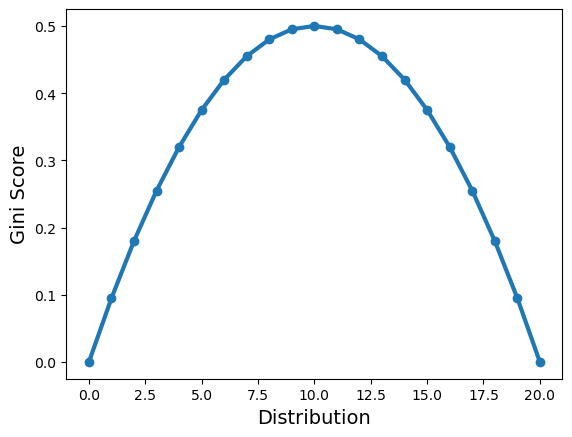

In [15]:
num_samples, gini_scores = 20, []

for num_no in range (0, num_samples+1):
    gini_scores.append(compute_gini_score_node(["NO"]*num_no + ["YES"]*(num_samples-num_no)))

plt.figure()
plt.plot(range(0, len(gini_scores)), gini_scores, marker='o', ls='-', lw=3)
plt.xlabel("Distribution", fontsize=14)
plt.ylabel("Gini Score", fontsize=14)
plt.show()

From the previous results, it is very clear that the lower the Gini score the better. In fact, if the node is completely pure &mdash; that is, the node only contains data samples from the same class, the Gini score is $0$. The maximum Gini score occurs when the classes are distributed as evenly as possible at a node. For a binary classification, this maximum is $0.5$, which happens when both classes are equally likely (as can be seen in the figure above). For more than two classes, the maximum impurity increases, reaching its theoretical upper bound at

$$\large
1 - \frac{1}{|C|}
$$

where $|C|$ is the number of classes, achieved when all classes have equal probability ($1/|C|$ each). Thus, the maximum Gini score does depend on the number of classes, and it approaches 1 as the number of classes grows. However, for the learning algorithm we only care about the relative score to find the smallest one(s).

So far, we can compute the Gini score for a node. But what we are really interested in is the Gini score of a split. After all, we want to find the split with the lowest Gini score. The Gini score of a binary split is computed by first calculating the scores of both child nodes $t_{\text{\textit{left}}}$ and $t_{\text{\textit{right}}}$. For the split, the overall Gini score is the **weighted average** of the score of $t_{\text{\textit{left}}}$ and $t_{\text{\textit{right}}}$, with weights given by the fraction of samples in each node. This weighting ensures that larger child nodes contribute more to the split's impurity than smaller ones, reflecting the true distribution of the data. The reason for this computation is that decision trees aim to minimize impurity across the dataset, so evaluating splits with respect to class proportions and sample sizes gives a fair measure of how well a split separates the classes. More more formally, the Gini score for a binary split is defined as:

$$\large
Gini(t_{left}, t_{right}) = \frac{n_{left}}{n}Gini(t_{left}) + \frac{n_{right}}{n}Gini(t_{right})
$$

where $n_{\text{\textit{left}}}$ is the number of data samples in the left child note $t_{\text{\textit{left}}}$, and $t_{\text{\textit{right}}}$ is the number data samples in the right child node $t_{\text{\textit{right}}}$; $n$ is the combined number of data samples, i.e., $n = n_{\text{\textit{left}}} + n_{\text{\textit{right}}}$. Of course, this definition can trivially be generalized beyond binary splits. To show and example, let's compute the Gini scores for the two alternative splits from before, starting with the one where we check if the marital status of a customer is *"Single"* not.

<img src="images/illustrations/decision-trees/dt-cart-alternative-splits-motivation-a.png" style="margin:auto;max-width:350px;width:100%" alt="CART Algorithm - Example Split 1">

<br />

Computing the Gini score simply boils down to plugging in the respective numbers into the formula. For example, with a total of $n=9$ samples, and $5$ samples in the left, and $4$ samples in the right node, the corresponding weights are $5/9$ and $4/9$. Similarly, all relative frequencies $P(c|t)$ stem directly from the number of occurrences of each class label in both nodes.

$$\begin{align}
\large Gini(s_{mstatus})\ &\large = \frac{5}{9}\left[ 1 - \left( \left(\frac{3}{5}\right)^2 + \left(\frac{2}{5}\right)^2\right) \right] + \frac{4}{9}\left[ 1 - \left( \left(\frac{2}{4}\right)^2 + \left(\frac{2}{4}\right)^2\right) \right]  \\[0.75em]
&\large = \frac{5}{9}\cdot 0.48\ +\ \frac{4}{9}\cdot 0.5  \\[0.75em]
&\large\approx 0.49
\end{align}
$$

Knowing that the maximum Gini score in case of binary classification is $0.5$, a score of around $0.49$ clearly indicates a pretty bad split. In this simple example it also obvious why would expect a bad score: The distribution in the right node is with 2x *"NO"* and 2x *"YES"* completely balanced (i.e., the worst case), but also the left node is still very impure showing a distribution of class labels is far from homogeneous. Let's do the same computation for the second split where the condition checks if the value for "Education" is *"Bachelor"* or not.

<img src="images/illustrations/decision-trees/dt-cart-alternative-splits-motivation-b.png" style="margin:auto;max-width:350px;width:100%" alt="CART Algorithm - Example Split 2">

Of course, the procedure is exactly the same, giving us the following formula and the following result.

$$\begin{align}
\large Gini(s_{education})\ &\large = \frac{3}{9}\left[ 1 - \left( \left(\frac{3}{3}\right)^2 + \left(\frac{0}{3}\right)^2\right) \right] + \frac{6}{9}\left[ 1 - \left( \left(\frac{1}{6}\right)^2 + \left(\frac{5}{6}\right)^2\right) \right]  \\[0.75em]
&\large\approx \frac{3}{9}\cdot 0.0\ +\ \frac{6}{9}\cdot 0.28  \\[0.75em]
&\large\approx 0.19
\end{align}
$$

The Gini score of this split is not significantly lower, overall confirming our intuition that the second split is the preferred one. Again, we can directly implement the formula of the Gini score; see the method `compute_gini_score_split()` in the code cell below. The input of the method is to list or arrays containing the class labels of each data sample reaching the left and right child node, respectively. Naturally, this method uses the method `compute_gini_score_split()` to compute the Gini score of the left and right child nodes, and then computes the weighted sum of both with respect to the number of samples in each child node.

In [16]:
def compute_gini_score_split(t_left, t_right):
    # Calculate the Gini score for the left and right node
    gini_score_left  = compute_gini_score_node(t_left)
    gini_score_right = compute_gini_score_node(t_right)
    # Calculate and return the weighted average Gini score
    return   len(t_left)/(len(t_left)+len(t_right))*gini_score_left \
           + len(t_right)/(len(t_left)+len(t_right))*gini_score_right

In the code cell below, we use the method `compute_gini_score_split()` to compute once more the Gini score for two example splits as before.

In [17]:
gini_mstatus   = compute_gini_score_split(["NO", "NO", "NO", "YES", "YES"],  ["NO", "NO", "YES", "YES"])
gini_education = compute_gini_score_split(["NO", "NO", "NO"], ["NO", "YES", "YES", "YES", "YES", "YES"])

print(f"Gini score of split s_mstatus:    {gini_mstatus:.2f}")
print(f"Gini score of split s_education:  {gini_education:.2f}")

Gini score of split s_mstatus:    0.49
Gini score of split s_education:  0.19


Of course, the numbers match the results we got from our "manual" calculation of the Gini scores.

We now have all the methods in place to enumerate all possible splits for a given feature, and to measure the impurity of a single split for classification tasks. Naturally, the Gini score as a measure of impurity assumes a distribution of nominal class labels as the input. We therefore still need another measure of impurity for distributions of numerical target values, i.e., for regression tasks. So let's look at this next.

#### Regression Tasks

In a regression task, we deal with numerical target values. This makes the notion of the impurity of a node and a split very intuitive: the more similar the target values within a node the lower the impurity. The similarity between the target values is commonly using the **Residual Sum of Squares (RSS)** measure which computes the sum a squares distances between the target values of all samples in a node and their mean. The RSS of a split $RSS_{split}$ is defined as:

$$\large
RSS_{split} = \sum_{k=1}^{K}\sum_{i\in R_{k}}\left(y_i - \mu_{R_k} \right)^2
$$

where $K$ is the number of child nodes (for CART: $K=2$), $R_k$ is the set of samples in child node $k$, and $\mu_{R_k}$ is the mean of the target values of the data samples in $R_k$. For example, let's again consider our small banking dataset. However, we now assume that we want to use the features "Age", "Education", and "Marital_Status", to predict "Annual_Income" as the target, thus making it a regression task. In short, the dataset now looks as follows:

In [18]:
df_bank.drop(["ID", "Credit_Default"], axis=1).head(10)

,Age,Education,Marital_Status,Annual_Income
0,23,Masters,Single,75000
1,35,Bachelor,Married,50000
2,26,Masters,Single,70000
3,41,PhD,Single,95000
4,18,Bachelor,Single,40000
5,55,Masters,Married,85000
6,30,Bachelor,Single,60000
7,35,PhD,Married,60000
8,28,PhD,Married,60000


To show an example for computing the RSS score for different splits, we consider the same two alternative splits for the root node we have used before (see above). The only difference here is, of course, now that we have to consider the target values of the data samples in the left and right child nodes for each split. The figure illustrates this.

<img src="images/illustrations/decision-trees/dt-cart-alternative-splits-motivation-rss.png" style="margin:auto;max-width:850px;width:100%" alt="CART Algorithm - Alternative Splits (Example for Regression)">

<br />

Let's start with the left split check if the marital status of a customer is *"Single"* or not. According to the formula for the RSS score, we first need to compute the means of both child nodes, which we can compute as shown below &mdash; note that in the following we ignore the `000` of the salaries to ease presentation:

$$\begin{align}
\large \mu_{R_{left}}\ &\large= \frac{75 + 70 + 95 + 40 + 60}{5} = 68\\[0.5em]
\large \mu_{R_{right}}\ &\large= \frac{50 + 85 + 60 + 65}{4} = 65\\[0.5em]
\end{align}
$$

With both means available, we can now compute the RRS score for the left split by simply plugging in the numbers into the given formula:

$$\begin{align}
\large RSS_{split}  &\large =           &\large\left[(75-68)^2 + (70-68)^2 + (95-68)^2 + (40-68)^2 + (60-68)^2 \right] \\[0.5em]
\large              &                   & \large + \left[(50-65)^2 + (85-65)^2 + (60-65)^2 + (65-65)^2 \right] \\[0.5em]
\large              &\large =           & \large 1630 + 650 = \mathbf{2280}
\end{align}
$$

Of course, to get the score for split on the right checking if the education level is *"Bachelor"* or not, we perform the exact same steps, starting with computing the two means:

$$\begin{align}
\large \mu_{R_{left}}\ &\large= \frac{50 + 40 + 60}{3} = 50\\[0.5em]
\large \mu_{R_{right}}\ &\large= \frac{75 + 70 + 95 + 85 + 60 + 65}{6} = 75\\[0.5em]
\end{align}
$$

Now we can once more compute the RSS score of that split using the given formula:

$$\begin{align}
\large RSS_{split}  &\large =           &\large\left[(50-50)^2 + (40-50)^2 + (60-50)^2 \right] \\[0.5em]
\large              &                   & \large + \left[(75-75)^2 + (70-75)^2 + (95-75)^2 + (85-75)^2 + (60-75)^2 + (65-75)^2 \right] \\[0.5em]
\large              &\large =           & \large 200 + 850 = \mathbf{1050}
\end{align}
$$

Since the RSS score of the split on the right side checking the education level is lower, this split would be preferred as it results in child nodes that are less impure (compared to the child nodes resulting from the split checking the marital status of bank customers). This means we now also have a way to score and find the best split in case of numerical targets for regression tasks, which is arguably more straightforward than for classification tasks.

Like for Gini scores, we can also implement a simple method that computes the RSS score for a split given the target values from both child nodes. Since we look at the CART algorithm, we limit ourselves to binary splits, but the implementation can easily be extended to splits with more than two branches. The method `compute_rss_score_split()` first computes the means for both arrays representing the target values of the left and right child node; it then computes the RSS scores for both child nodes before adding them together and returning the final score. By using basic methods provided by the NumPy library, all steps are very easy and very efficiently to implement.

In [19]:
def compute_rss_score_split(t_left, t_right):
    # Compute the mean of both child nodes
    mean_left  = np.mean(t_left) 
    mean_right = np.mean(t_right)
    # Calculate the Gini score for the left and right node
    rss_score_left  = np.sum(np.square(t_left - mean_left))
    rss_score_right = np.sum(np.square(t_right - mean_right))
    # Calculate and return the final RSS score
    return rss_score_left + rss_score_right

Let's apply the method on two inputs representing the two alternative splits from before.

In [20]:
rss_mstatus   = compute_rss_score_split([75, 70, 95, 40, 60],  [50, 85, 60, 65])
rss_education = compute_rss_score_split([50, 40, 60],  [75, 70, 95, 85, 60, 65])

print(f"RSS score of split s_mstatus:    {rss_mstatus:.2f}")
print(f"RSS score of split s_education:  {rss_education:.2f}")

RSS score of split s_mstatus:    2280.00
RSS score of split s_education:  1050.00


Unsurprisingly, we get the same RSS scores as we got from computing "by hand".

### Putting it all Together

Enumerating all possible splits and appropriately scoring them with respect to the level of impurity are core steps of the CART algorithm &mdash; and for most other Decision Tree learning algorithms. Finding the best split for a current internal node essentially only means putting the relevant methods together. To show this, let's convert our toy dataset into a proper training dataset containing a feature matrix `X` and target vector `y`. This includes also removing column "ID" as it arguably does not represent a meaningful feature to be considered for the training.

In [21]:
X = df_bank.drop(["ID", "Credit_Default"], axis=1).to_numpy()
y = df_bank["Credit_Default"].to_numpy()

print(f"Feature matrix X:\n{X}\n")
print(f"Target vector y: {y}")

Feature matrix X:
[[23 'Masters' 'Single' 75000]
 [35 'Bachelor' 'Married' 50000]
 [26 'Masters' 'Single' 70000]
 [41 'PhD' 'Single' 95000]
 [18 'Bachelor' 'Single' 40000]
 [55 'Masters' 'Married' 85000]
 [30 'Bachelor' 'Single' 60000]
 [35 'PhD' 'Married' 60000]
 [28 'PhD' 'Married' 60000]]

Target vector y: ['NO' 'YES' 'NO' 'NO' 'YES' 'YES' 'YES' 'NO' 'NO']


To find the overall best plot, let's first define a method that finds the best split with respect to a single feature. The method `find_best_feature_split()` below takes in as input a list of feature vectors, the list of target values, as well as the information about the type of feature, mainly if "nominal" or something else. The method needs this information to determine (a) if it needs to compute all thresholds for non-nominal features or all partitions for nominal features, and (b) what measure of impurity to apply on the target values (Gini or RSS). Beyond that, the method then simply iterates through all possible thresholds or partitions &mdash; collectively referred to as criterions &mdash; and computes and scores each resulting split. During this loop the method keeps track of all the core information describing the current best split, and returns this information about the best split at the end.

In [22]:
def find_best_feature_split(x, y, feature_type):
    ## Initialize the return values
    best_score, best_criterion, best_split = np.inf, None, None

    # Create splits depending on the feature being nominal or nonnominal
    if feature_type == "nominal":
        criterions = compute_partitions(x)
        generate_split = generate_split_nominal
    else:
        criterions = compute_thresholds(x)
        generate_split = generate_split_general

    # Check all thresholds/partitions to find the one yielding the lowest Gini score
    for criterion in criterions:
        # Generate the split for the current threshold/partition
        split = generate_split(x, criterion)
        # Split the target values w.r.t. indices
        y_left, y_right = y[split[0]], y[split[1]]
        # Compute the Gini score for the current split
        score = compute_gini_score_split(y_left, y_right)
        # Keep track of the key information of the split with the lowest Gini score
        if score < best_score:
            best_score, best_criterion, best_split = score, criterion, split

    # Return key information of best split
    return best_score, best_criterion, best_split

The code cell below allows you to execute the method `find_best_feature_split()` for all of the four input features. Notice, again, that we treat "Education" as a nominal feature here for convenience. In practice, we could treat "Education" as ordinal (i.e., non-nominal) features by converting each string value into an integer value such that we preserve the natural order/ranking between the values.

In [23]:
score, critierion, split = find_best_feature_split(ages, y, "ratio")
#score, critierion, split = find_best_feature_split(educations, y, "nominal")  # Should return the lowest score
#score, critierion, split = find_best_feature_split(mstatuses, y, "nominal")
#score, critierion, split = find_best_feature_split(incomes, y, "ratio")

print(f"Gini score: {score:.2f}")
print(f"Criterion:  {critierion}")
print(f"Split:      {split}")

Gini score: 0.42
Criterion:  20.5
Split:      (array([4]), array([0, 1, 2, 3, 5, 6, 7, 8]))


Finding the split across all features works in a similar way, only that we now (a) iterate over each individual feature, (b) use method `find_best_feature_split()` to find the best split regarding the current feature, and (c) keep track of the feature the yields the lowest Gini score. The method `find_best_split()` in the code cell below implements these basic steps. Of course, this method now needs as additional input the types of all features.

In [24]:
def find_best_split(X, y, feature_types):
    # Initialize the return values
    best_score, best_criterion, best_column, best_split = np.inf, None, None, None
    # Check for each feature (i.e., each column in X), which split has the best (lowest) score
    for column in range(X.shape[1]):
        # Extract feature values from datasets
        x = X[:,column]
        # Calculate the best split for the current column/feature
        score, threshold, split = find_best_feature_split(x, y, feature_types[column])
        # Keep track of the key information of the split with the lowest Gini score
        if score <= best_score:
            best_score, best_column, best_split, best_threshold = score, column, split, threshold
    # Return the best split together with the relevant information
    return best_score, best_column, best_threshold, best_split

Applying this method to our training dataset represents finding the first best split at the root node. It turns out that we indeed should check first if the education of a bank customer is *"Bachelor"* or not.

In [25]:
score, column, critierion, split = find_best_split(X, y, ["ratio", "nominal", "nominal", "ratio"])

print(f"Gini score: {score:.2f}")
print(f"Column:     {column} ({df_bank.columns[column+1]})")
print(f"Criterion:  {critierion}")
print(f"Split:      {split}")

Gini score: 0.19
Column:     1 (Education)
Criterion:  ({'Bachelor'}, {'PhD', 'Masters'})
Split:      ([1, 4, 6], [0, 2, 3, 5, 7, 8])


This, of course, gives us only the root split and not the full Decision Tree. After all, we already know that the left child node is still impure and therefore requires at least one more split. It is arguably easy to see how this process continuous recursively: Both partitions $[1, 4, 6]$ and $[0, 2, 3, 5, 7, 8]$ identify the subset data samples that will form the new data matrix `X` and target vector `y` with respect to both new child nodes. However, these are rather implementation details and involve important design decisions regarding the learning algorithm. The important, but arguably obvious, detail is when this recursive process of splitting stops. We stop splitting a node if the node is 100% &mdash; that is, either if all target labels are of the same class, or if all target values are the same.

We also skipped how we can use a Decision Tree to actually make predictions. But again, this just comes down to recursively checking internal nodes to see which branch to which leaf node to follow, which is also easy to implement. If you are interested, we provide a complete implementation of the CART algorithm training full Decision Trees from scratch. Most of the methods in the class `SeleneCART` are the ones we introduced above. The method `fit()` to train the Decision Tree mimics the API from scikit-learn. Note that this implementation only supports classification tasks, although it could easily be extended to numerical targets as well. Let's use this implementation to train a full Decision Tree for our small banking dataset.

In [26]:
cart = SeleneCART(["ration", "nominal", "nominal", "ratio"]).fit(X, y)

The class `SeleneCART` also provides a simple method to "print" the learned Decision Trees using text characters only.

In [27]:
print(cart)

 X[1], criterion: ({'Bachelor'}, {'PhD', 'Masters'}), gini: 0.494, samples: ['NO' 'YES' 'NO' 'NO' 'YES' 'YES' 'YES' 'NO' 'NO']
--- Leaf, gini: 0.000, samples: ['YES' 'YES' 'YES']
--- X[0], criterion: 48.0, gini: 0.278, samples: ['NO' 'NO' 'NO' 'YES' 'NO' 'NO']
------ Leaf, gini: 0.000, samples: ['NO' 'NO' 'NO' 'NO' 'NO']
------ Leaf, gini: 0.000, samples: ['YES']



If you carefully check the output above, you will notice that the Decision Tree that we have just learned is one of the possible trees we visualized at the beginning as an example; see the figure below. The only minor difference is that the threshold we used for "Age" for the second split in the figure is $50$. However, since implementation computes indeed the midpoints between all unique feature values, the actual threshold is indeed $48$.

<img src="images/illustrations/decision-trees/dt-banking-example-02.png" style="margin:auto;" alt="Decision Tree for Banking Example">

<br />

Although we do not explicitly discuss the methods involved in making predictions, we can still show an example. Again, we align our implementation with the API of scikit-learn and named the method `predict()`. To make a prediction, we first have to create a new data sample. So let's just create the sample *(50, "PhD", "Single", 70000)* we have already used before to show that two different trees may yield different predictions for the same data sample.

In [28]:
x_test = [50, "PhD", "Single", 70000]

print(f"Prediction for {x_test}: {cart.predict([x_test]).tolist()}")

Prediction for [50, 'PhD', 'Single', 70000]: ['YES']


**Summary:** We have now covered all essential ingredients required to train a Decision Tree using the CART algorithm. During the section, you may have already noticed some challenges and other concerns. Most importantly, the number of possible thresholds or partitions can be very large, particularly for large datasets where we can assume to see a large number of unique values (nominal or non-nominal). While this search space does not grow exponentially with the number of data samples $n$, it potentially still requires checking many splits to find the best one. Also, right now we have to explicitly specify the types of each feature. While not completely impractical, common implementations of the CART algorithm avoid this step but also consider other issues such as missing values.

### Tree Pruning

The main component of the original CART algorithm covered in this section builds a "full" Decision Tree. However, a fully grown decision tree is prone to **overfitting** because it keeps splitting the data until each leaf is as pure as possible, often down to single training examples. While this minimizes training error, it also means the tree is capturing not just the true underlying patterns but also the random noise and idiosyncrasies in the dataset. As a result, the tree becomes overly complex, with many branches that describe very specific conditions that may not hold in new, unseen data. This over-specialization reduces the model's ability to generalize. Instead of learning broad, robust rules, the tree essentially memorizes the training data structure. Consequently, although the full tree achieves low error on the training set, it typically performs poorly on test data because the patterns it encodes do not reflect the true distribution but rather artifacts of the sample. We will illustrate this problem later in more detail.

To counter this, the original CART algorithm uses **cost-complexity pruning** (also called weakest-link pruning) as a way to simplify an overly large decision tree while balancing accuracy and model complexity. The idea is to start with a large, fully grown tree that may overfit the training data, and then iteratively prune it back by removing subtrees that provide the least improvement in predictive performance relative to their complexity. For each candidate subtree, CART defines a cost-complexity measure that combines the misclassification error (or impurity) with a penalty proportional to the number of terminal nodes (leaves). Formally, this is expressed as $R_\alpha(T) = R(T) + \alpha |T|$, where $R(T)$ is the error of the tree $T$, $|T|$ is the number of leaves, and $\alpha \geq 0$ is a complexity parameter. Increasing $\alpha$ encourages smaller trees by penalizing complexity more heavily. The algorithm generates a nested sequence of trees by progressively pruning the weakest subtrees (those whose removal increases the cost-complexity criterion the least). Finally, cross-validation is used to select the $\alpha$ (and corresponding pruned tree) that best generalizes to unseen data.

The pruning strategy of the original CART algorithm is considered **post-pruning** since it first grows the full tree and then prunes subtrees. Most practical implementation of the CART algorithm utilize more efficient **pre-pruning** strategies. Such strategies use different measures to decide when a node should no longer be split, even if it is not pure. In short, pre-pruning avoids growing a full Decision Tree. We therefore omit a more detailed discussion of cost-complexity pruning (post pruning) here but motivate and introduce the concept of pre-pruning in the next section.

---

## Practical Implementations & Optimizations

The original CART algorithm is a clean and theoretically elegant framework for training decision trees. However, in practice, directly following the algorithm can be computationally expensive and sometimes impractical on modern large-scale datasets. For example, CART considers **all possible splits** for continuous features and even explores surrogate splits for handling missing values—steps that are feasible for small datasets but become prohibitively slow when working with millions of samples and high-dimensional data.

As a result, practical implementations often introduce **approximations and optimizations** to make decision tree training scalable. These include restricting the set of candidate thresholds (e.g., using quantiles or histograms), simplifying how categorical variables and missing values are handled, and using heuristics instead of exhaustive search. While these modifications deviate from the theoretical purity of CART, they allow decision trees—and tree-based ensembles like Random Forests and Gradient Boosted Trees—to remain efficient, robust, and highly effective on large structured datasets.

Let's look at some of the most common extensions and modifications of the original CART algorithm.

### Handling of Categorical Features

The basic CART algorithm supports both categorical (nominal and ordinal) and numerical (interval and ratio) features. While ordinal features can easily be converted into order-preserving numerical features, nominal features have to be treated separately since enumerating all possible splits works differently. Instead of finding all possible (and meaningful) thresholds, nominal features split based on partitioning the features values. This has some practical consequences, most importantly with respect to the performance.

#### Ease of Use

Although arguably a minor concern, recall that in our example implementation above, we had to explicitly specify the type for each feature: `[ratio, nominal, nominal, ratio]` for the four features "Age", "Education", "Marital_Status", and "Annual_Income". This is only needed because we have to treat nominal features differently to the other types. Note that type of a feature cannot be reliably derived by the algorithm itself as it generally requires domain knowledge about the dataset. For example, even if a phone is represented as a number, it is usually considered a nominal value (i.e., just a label) since there is no meaningful order defined over phone numbers. Similarly for strings, we already discussed that the feature "Education" could be treated as a nominal or ordinal feature as part of the decision process when analysing the data or using it for model training.

As such, many implementations of the CART algorithm address this by expecting only numerical features. This means that the additional consideration of categorical features has been done as part of the data preparation step. We already saw that this is relatively easy; we only need to ensure that the order/ranking of feature values is preserved. Converting nominal features into numerical ones is typically less straightforward. Nominal data, which represents categories without inherent order (e.g., colors, names, product types), must be converted into numerical form for most machine learning algorithms. The most common strategy is **one-hot encoding**, where each category becomes a binary feature (1 if present, 0 otherwise). While simple and widely used, it can lead to high-dimensional data if there are many unique categories. More advanced methods include **target encoding** (replacing categories with the mean of the target variable for each category), **frequency/count encoding** (replacing categories with their frequency of occurrence), and **embedding-based encoding** (learning dense vector representations of categories, often used in deep learning). Each method has its pros and cons balancing trade-offs between dimensionality, interpretability, and model suitability, and the choice depends on the dataset characteristics.

Of course, if the implementation of the CART algorithm only accepts numerical inputs, there is no longer any need to explicitly specify the types of features. We even do not have to distinguish between interval and ratio features since CART only performs comparison of the form *"feature $\leq$ threshold?"* and no arithmetic operations. Limiting the CART algorithm to numerical inputs not only makes it a bit easier to use and implement &mdash; after all, we can remove all the bits that are required to handle nominal data &mdash; it also helps to address performance considerations, as we will see next.

#### Performance & Efficiency

The basic CART algorithm has to evaluate $(k-1)$ and $(2^k-1)$ possible splits for non-nominal and nominal features, respectively, with $k$ being the number of unique values of a feature. Particularly the number of $(2^k-1)$ possible splits for non-nominal features can be a problem in practice if the number of unique features values $k$ becomes large. One solution, as we just saw, is to convert a nominal feature into one or more numerical features using appropriate encoding strategies (one-hot encoding, target encoding, frequency encoding, etc.), which can bring down the number of splits to $(k-1)$. Besides this approach there are other strategies to address performance issues. Again, we can distinguish between non-nominal and nominal features.

##### Non-Nominal Features

Popular implementations such as the [`DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) and [`DecisionTreeRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) class of the scikit-learn library do indeed consider and evaluate all $(k-1)$ possible splits. But again, if the number of unique values $k$ is very large &mdash; which is not unlikely for numerical features and large datasets &mdash; this quickly can negatively affect the training performance. Also, if many values and therefore many thresholds are very similar, the observation is that many thresholds result in splits with very similar or even the same Gini or RSS score. Thus, the basic approach is to only evaluate a subset of all possible thresholds.


A practical workaround to accomplish this is to approximate the continuous feature distribution by **binning** values into a fixed number of intervals (bins) or by building a **histogram**. Instead of testing every possible split, the algorithm only considers thresholds at the bin boundaries or representative values (like bin means). This reduces the number of candidate splits from potentially thousands (or more) to just the number of bins, making the algorithm significantly faster. The figure below shows an example for binning by adopting the previous example showing the basic approach of using all midpoints between unique values as thresholds. Here, we split the feature values into bins of size $3$, and use only the midpoints between the boundaries of adjacent bins as the thresholds.

<img src="images/illustrations/decision-trees/dt-cart-nonnominal-thresholds-binning.png" style="margin:auto;max-width:600px;width:100%" alt="CART Algorithm - Binning Example">

<br />

How the bins or the histograms are generated depends on the exact algorithm, with fixed-count binning (all bins contain the same number of data samples), fixed-width binning (all bins capture same range in the feature space), and quartile-based binning (bin can have different width depending on the data distribution) the most common strategies. The overall idea is the same: limiting the number of splits that need to be evaluated in a meaningful and systematic manner. Approach such as binning where the thresholds are the means from some feature values also can help to reduce overfitting to due small fluctuations or noise in the data &mdash; an Decision Trees can be rather susceptible to noise (see the introductory notebooks about Decision Trees for more details). 

On the other, there is always the risk of approximation errors if we miss a threshold that would actually give us the best split. There is also no obvious choice for the number of bins or the granularity of the histogram. For example, while only using a few bins means more computational saving, it also means a higher risk of approximation error &mdash; and vice versa when using many bins. Histogram-based algorithms are therefore often used in tree-based ensemble methods such as **LightGBM**, **CatBoost**, or **XGBoost**, where the whole model comprises many trees and approximation errors across all three more or less cancel out.

##### Nominal Features

In the case of nominal features, the fundamental goal is to somehow restrict the number of considered splits to avoid the maximum number of $(2^k-1)$ possible splits. The most basic strategies is to impose an ordering through **target encoding**. Target encoding is a method for converting nominal (categorical) features into numerical values by replacing each category with a statistic derived from the target variable. Instead of creating many binary indicators (as in one-hot encoding), target encoding captures the relationship between the category and the target in a single numeric value, which can be more compact and predictive. For regression tasks, target encoding usually replaces each category with the **mean target value** of the samples belonging to that category. For classification tasks, target encoding replaces each category with the **class probability distribution**. For multi-class classification, one can encode a category with a vector of probabilities across all classes.

To better get the idea, let's look at an oversimplified example of our bank customer data. The dataset in the table below shows only one input feature, "Education", and the two possible targets "Credit_Limit" (regression) and "Credit_Default" (binary classification).

| Education     | Credit_Limit | Credit_Default |
| ------------- | ------------ | -------------- |
| Bachelor      | 200          | YES (1)        |
| Bachelor      | 220          | NO (0)         |
| Masters       | 150          | YES (1)        |
| Masters       | 180          | NO (0)         |
| Masters       | 240          | NO (0)         |
| Phd           | 300          | NO (0)         |

For the regression task predicting the credit limit, we can compute the the mean target value for each education level: "Education" $\rightarrow (200+220)/2 = 210$, "Master" $\rightarrow (150+180+240)/2 = 190$, and "PhD" $\rightarrow (300)/1 = 300$. For the classification predicting whether customers are likely to default on the credit, we can compute compute the class distribution for each education level: "Education" $\rightarrow (0+1)/2 = 0.5$, "Master" $\rightarrow (1+0+0)/3 = 0.33$, and "PhD" $\rightarrow (0)/1 = 0$ (we just need a single new feature since we only have two classes). The resulting dataset containing the two new features encoding "Education" is shown below:

| Education     | Credit_Limit | Credit_Default | Edu_enc_regression | Edu_enc_classification |
| ------------- | ------------ | -------------- | ------------------ | ---------------------- |
| Bachelor      | 200          | YES (1)        | 210                | 0.5                    |
| Bachelor      | 220          | NO (0)         | 210                | 0.5                    |
| Masters       | 150          | YES (1)        | 190                | 0.33                   |
| Masters       | 180          | NO (0)         | 190                | 0.33                   |
| Masters       | 240          | NO (0)         | 190                | 0.0                    |
| Phd           | 300          | NO (0)         | 300                | 0.0                    |

After the encoding, we can treat the information about the education level of the customers as a numerical value, bringing the number of possible splits down to $(k-1)$. While target encoding is a common strategy applied during data preprocessing/preparation, it can also be implemented as part of the Decision Tree learning algorithm itself. Note that practical implementations often do not use raw averages (especially if a category has very few samples), but apply smoothing techniques or compute values using cross-validation to prevent data leakage. Similar to non-nominal features, methods such as binning can be applied to further reduce the number of splits to be evaluated.

### Handling of Missing Values

The original CART algorithm assumes that all feature values are available when evaluating candidate splits, which means it cannot naturally handle missing values in the training data. This is problematic because real-world datasets almost always contain missing entries due to errors in data collection, privacy restrictions, or unrecorded measurements. The most straightforward solution is to handle missing value as part of the cleaning and preparation of the training data (e.g., discarding data samples with missing data, or suitable imputation strategies). However, the simplicity of the CART and other Decision Tree learning algorithms also allow for the handling of missing values as part of the learning algorithm itself.

#### "Best Guess" Strategy

This approach first finds the best split by ignoring all missing values. Once we identified the feature that is associated with the best split &mdash; and this features does indeed have missing values for some set $S$ of data samples &mdash; we check whether moving all samples in $S$ to the left or the right child yields a lower Gini score, and then move them there and continue as usual. The only thing we need to remember is where we moved data samples at this particular split (i.e., internal node). When making predictions, and we have an unseen data sample reaching this internal node and having a missing value for the relevant feature, we follow the branch we remembered during training.

This extension to the original CART algorithm is quite straightforward and easy to implement. However, there is always the chance that for some data samples with missing values we might make a very bad decision. The general assumption is that each prediction takes a lot of decisions into account and one single decision will only have a limited effect. Also, when making predictions, an unseen data sample with a missing value for feature $x_i$ might not even reach an internal node that checks $x_i$.

#### Surrogate Splits

Surrogate splits are a strategy used in Decision Tree training (e.g., in the original CART algorithm) to handle missing values in feature data. The main idea is that when the best split for a node (the **primary split**) cannot be applied because a data point is missing the required feature value, the algorithm looks for an alternative feature &mdash; called a **surrogate split** &mdash; that partitions the data in a way most similar to the primary split. In other words, surrogate splits act as "stand-ins", mimicking the decision boundary of the primary split as closely as possible. During training, the algorithm identifies surrogate splits by ranking other features according to how well their splits agree with the primary split. At inference time, if a sample is missing the value for the primary feature, the tree checks the surrogates in order until one can be applied, ensuring that the sample still gets routed down a branch. This approach maintains predictive power without discarding incomplete data, while also giving insights into feature correlations since good surrogates often capture similar information to the primary split.

The main limitation of surrogate splits is that they add **computational overhead**. For every split in the tree, the algorithm must search for and rank alternative splits across other features, which increases training time &mdash; especially in high-dimensional datasets. At inference time, evaluating surrogate splits can also slow down predictions since multiple fallbacks may need to be checked for each missing value. Another downside is that surrogate splits are only as good as the correlations between features. If no other feature strongly mimics the primary split, the surrogate will perform poorly, potentially sending samples down suboptimal branches. This can reduce accuracy compared to more robust missing value handling methods (e.g., imputation). Moreover, surrogate splits may amplify **feature biases**, since correlated features tend to dominate both primary and surrogate choices, limiting diversity in the decision process. Finally, surrogate splits do not fundamentally solve the missing data problem &mdash; they only provide a workaround &mdash; so if missingness is systematic (not random), the tree can still inherit that bias.

### Handling Overfitting & Underfitting: Pre-Pruning

The original CART grows a full tree and then prunes it back using cost-complexity pruning. This is done because a fully grown decision tree tends to overfit the training data, capturing noise and irregularities that do not generalize well. In short, fully grown Decision Trees are prone to **overfitting**. To illustrate this idea, let's look at another toy dataset consisting of 33 data samples with two features $x_1$ and $x_2$ for a binary classification task. As usual, we first load the data from file into a Padas DataFrame and the convert into NumPy arrays to represent the feature matrix `X` and the target vector `y`:

In [29]:
# Load data file into Pandas DataFrame
df_cart = pd.read_csv(cart_data)

#Convert DataFrame into feature matrix and target vector
X = df_cart.drop(["y"], axis=1).to_numpy()
y = df_cart["y"].to_numpy()

We provide the auxiliary method `plot_cart_data()` to show the data distribution; just run the code cell below to generate the plot. The colors of the data sample indicate the class label. Note that the plots do not show axis labels since they are not needed in the following.

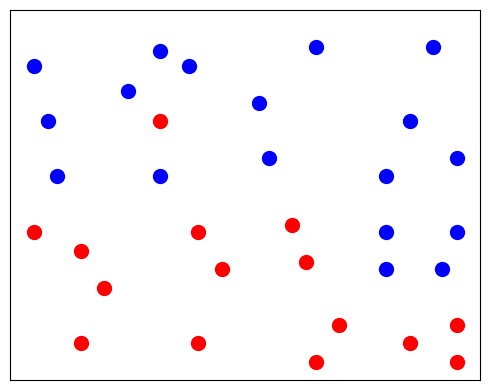

In [30]:
plot_cart_data(X, y)

<br />

Overall, the dataset shows a fairly straightforward distribution with respect to the classes. However, the top-most red data sample seems a little bit "out of place" as it sits within a generally blue region of the distribution. If such data samples are outliers due to noise, they can negatively affect test performance of fully grown Decision Trees. Let's actually use this dataset to train different Decision trees to get a better intuition for this phenomena.

To train a Decison Tree, we use the [`DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) class of the scikit-learn library. Since our two features are both numerical, and by default the class returns a fully grown tree, it performs exactly like the original CART algorithm &mdash; except this class does not implement any post-pruning. As the code cell below shows, training a Decision Tree using [`DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) class basically just requires a single line of code. Once the Decision Tree is trained, we can also visualize using another auxiliary method `plot_decision_tree()`.

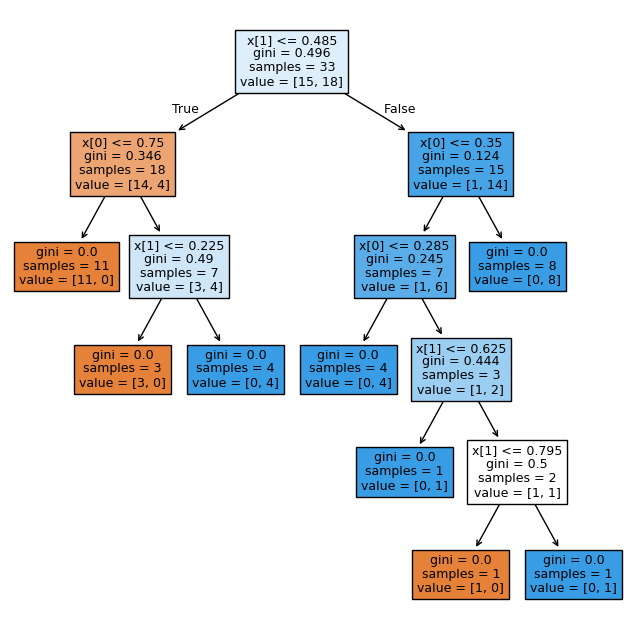

In [31]:
tree_full = DecisionTreeClassifier().fit(X, y)

plot_decision_tree(tree_full)

Since the dataset does not contain multiple data samples with the same feature values but different class labels, all leaf nodes are completely pure. We can also see that the tree already looks fairly large despite the small dataset size and overall simple data distribution. In fact, the main reason for this is the single red outlier. To better visualize this, we can again plot all data samples but not also include the resulting decision boundaries of the trained tree. The method `plot_cart_data()` accomplishes this if a trained model (here, a Decision Tree) is provided as input parameter.

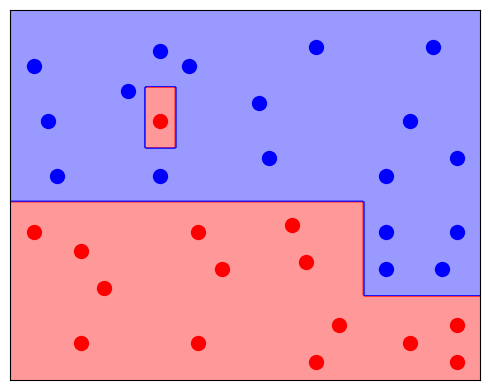

In [32]:
plot_cart_data(X, y, model=tree_full)

<br />

Firstly, notice that the Decision Boundaries are a combination for horizontal and vertical lines because each decision at an internal node is a simple comparison based on a single feature (and threshold). But more importantly, the decision boundaries show this small red area. Every new, unseen data sample that would fall into this area would be labeled *red* when it probably should be *blue* considering the overall distribution. This fully grown Decision Tree will arguably no generalize well over unseen data because it fitted the noise in the training data &mdash; in short: the tree is **overfitting**.

While the original CART algorithm addresses this issue by pruning a fully grown tree (i.e., post-pruning), most modern libraries implement pre-pruning strategies by including additional stopping rules to prevent overfitting and reduce computational cost. In general, these rules decide whether an internal node &mdash; even if the node is not pure &mdash; should be split further or converted into a leaf node. Early stopping rules (also called **pre-pruning criteria**) are conditions that prevent a decision tree from growing too deep or too complex during training. Instead of first growing a full tree and pruning later, these rules stop the splitting process once further growth is unlikely to improve generalization. Common rules include:

* **Maximum depth:** Stop splitting once a predefined tree depth is reached. This limits model complexity and ensures the tree does not grow arbitrarily deep.

* **Minimum samples per split / per leaf:** Require a node to have at least a certain number of training samples to be split. Similarly, enforce that each leaf must contain at least a minimum number of samples. This avoids overly specific rules based on very small subsets of data.

* **Maximum number of leaves / nodes:** Impose a global cap on the number of leaves or nodes in the tree. Once this limit is reached, the tree stops growing.

* **Impurity threshold:** Stop splitting if the reduction in impurity (e.g., Gini index, variance) from the best candidate split is smaller than a chosen threshold. This avoids unnecessary splits that add little predictive value.

* **Early stopping via validation set:** Some implementations check performance on a held-out validation set during training, and stop splitting when additional splits no longer improve validation accuracy.

In practice, most libraries (incl. scikit-learn) allow a combination of these rules, giving fine-grained control over the balance between tree complexity and generalization. In the following, to give an example, we consider the maximum depth of a Decision Trees as a stopping rule. For this, [`DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) class of the scikit-learn library features the input argument `max_depth`. In the code cell below, we train and plot another Decision Tree over our toy dataset but not enforcing a maximum depth of $3$.

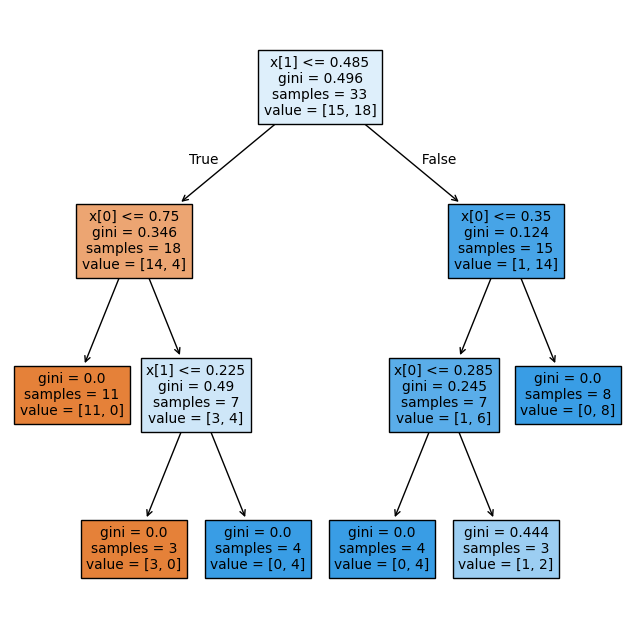

In [33]:
model_maxdepth3 = DecisionTreeClassifier(max_depth=3).fit(X, y)

plot_decision_tree(model_maxdepth3)

By restricting maximum depth, the Decision Tree is now missing the "lowest" subtree of the fully grown tree. Again, to better appreciate the effect of this change, let's plot the new decision boundaries for the pre-pruned tree.

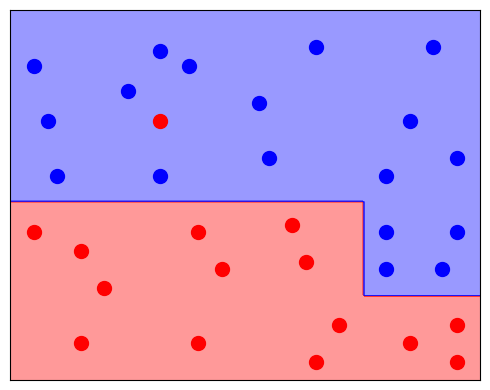

In [34]:
plot_cart_data(X, y, model_maxdepth3)

<br />

These decision boundaries are arguably better: they still capture the overall data distribution rather well, but they are no longer prone to the noise. We can therefore expect this tree to generalize better over unseen data compared to the fully grown tree. Of course, limiting the maximum depth too much will also cause problems. To see this, we can train and plot a third Decision Tree but not enforce a maximum depth of only $2$.

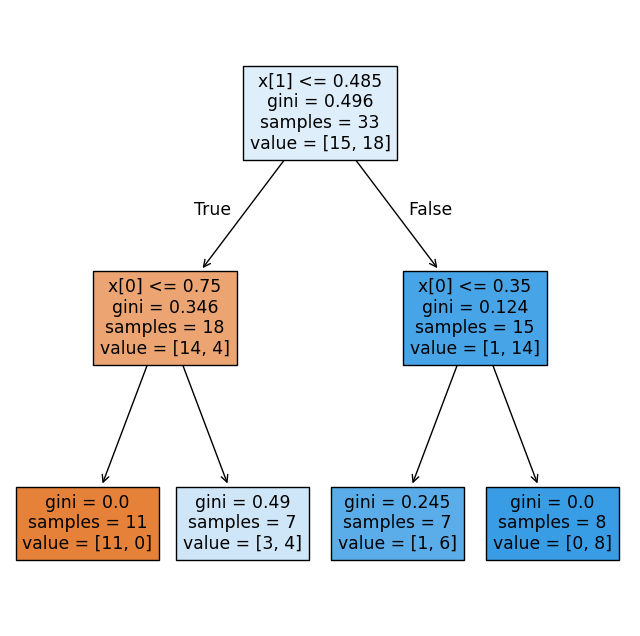

In [35]:
model_maxdepth2 = DecisionTreeClassifier(max_depth=2).fit(X, y)

plot_decision_tree(model_maxdepth2)

Further limiting the maximum depth naturally speeds up the training since we perform fewer splits. However, the results are also likely to no longer have enough complexity/capacity to fit the training data well. This means our model is **underfitting** We can best see this again when looking at the decision boundaries once more.

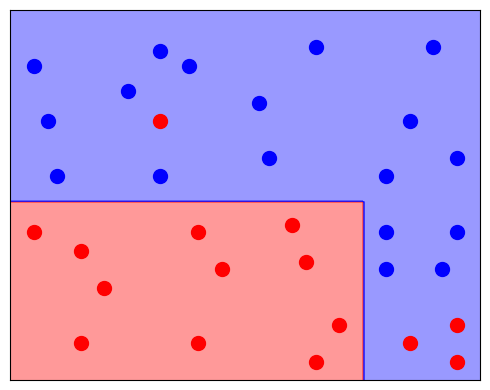

In [36]:
plot_cart_data(X, y, model_maxdepth2)

<br >

This Decision Tree now fails to capture more general trends in the data distribution; see bottom-right corner of the plot where the three red data samples should arguably form a red area.

Beyond `max_depth`, the [`DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) class provides other arguments to define different types of stopping rules including `min_samples_split` (the minimum number of samples required to split an internal node), `min_samples_leaf` (the minimum number of samples required to be at a leaf node), `min_impurity_decrease` (a node will be split if this split induces a decrease of the impurity greater than or equal to this value) and others, which can also combine for fine-grained rules. The downside of this flexibility by having various parameters to define stopping rules is the challenge to find the optimal values for those parameters. This is typically done using methods such as **cross-validation**, where different trees are trained with different stopping rules and evaluated on some unseen validation dataset.

Using cross-validation to tune early stopping parameters in Decision Tree training (such as maximum depth, minimum samples per split, or minimum impurity decrease) can be computationally expensive because it requires training multiple trees repeatedly. For each candidate parameter setting, the algorithm must grow a tree on multiple folds of the training data and then evaluate its performance on the validation folds. Since decision tree construction involves recursively evaluating many potential splits at each node (which is itself computationally heavy, especially for large datasets or high-dimensional data), repeating this process across many folds and parameter combinations quickly multiplies the cost. Moreover, early stopping parameters interact in non-trivial ways &mdash; e.g., a shallower maximum depth might behave differently depending on minimum split size &mdash; so exploring the parameter space often requires testing many combinations. This means the cross-validation procedure essentially simulates training dozens or even hundreds of full trees, making it significantly more expensive than training a single tree without tuning.

A common best practice to address the computational cost of cross-validation in Decision Tree parameter tuning is to limit the search space and use more efficient search strategies. Instead of exhaustively trying all parameter combinations (grid search), practitioners often rely on **randomized search** or **Bayesian optimization**, which sample or prioritize promising parameter regions while reducing the number of models trained. Another strategy is to use smaller subsets of the data during initial tuning to quickly narrow down plausible ranges, and then refine the search on the full dataset. Additionally, practitioners often use simpler validation strategies such as a single train–validation split, stratified sampling, or **k-fold cross-validation with fewer folds** (e.g., 3 instead of 10) when datasets are large. Finally, using **ensemble methods** like Random Forests or Gradient Boosted Trees (see below), which have built-in robustness and regularization, can reduce the need for fine-grained tuning of early stopping parameters in a single tree, thereby improving efficiency without losing much predictive power.

### Integration into Ensembles

The original CART algorithm is a standalone tree learner. Individual Decision Trees tend to suffer from **high variance**: small changes in the training data can lead to very different splits and, therefore, completely different trees. This makes them unstable and prone to overfitting, especially when the tree is allowed to grow deep without pruning or early stopping. Another limitation is that Decision Trees can be **biased toward features with many possible splits** (e.g., categorical variables with many levels), which may not necessarily carry the most predictive power. Furthermore, they often produce decision boundaries that are axis-aligned and piecewise constant (see the decision boundary plots above), which may not capture more complex relationships between features. 

Therefore, in practice, Decision Trees learning algorithms &mdash; and particularly CART or CART-style trees &mdash; are often used as **base learners in ensembles**. The basic idea of using Decision Trees as base learners in ensemble methods is that, although individual trees are weak and unstable predictors, their weaknesses can be overcome by combining many of them. Methods like **bagging** (e.g., Random Forests) reduce variance by averaging the predictions of many trees trained on different bootstrap samples, while **boosting** (e.g., Gradient Boosted Trees) reduces bias by sequentially training trees that correct the errors of previous ones. In both cases, the ensemble leverages the diversity and adaptability of trees to produce a much stronger overall model. When aggregated in an ensemble, Decision Trees achieve high predictive accuracy, robustness to overfitting, and better generalization compared to a single tree, while still retaining some interpretability (e.g., feature importance measures). This makes them particularly powerful base learners in modern machine learning. In short, while individual Decision Trees are intuitive, fast to train, and easy to interpret, they often perform worse than ensemble methods in terms of predictive accuracy.

**Summary.** The table below provides a brief summary of the main differences between the original CART learning algrithms and (most) practical implementations. The difference mainly address practical considerations such training and inference efficiency but also data-related issues such as missing values.

| Aspect                     | Original CART (Breiman et al., 1984)        | Practical Implementations (e.g., scikit-learn, XGBoost) |
|-----------------------------|--------------------------------------------|----------------------------------------------------------------|
| **Splitting Criterion**     | Binary splits based on impurity (Gini, variance) | Same, but may include optimizations (e.g., approximate splits, histogram binning) |
| **Handling Missing Values** | Assumes complete data                     | Imputation during preprocessing, surrogate splits,        |
| **Tree Growth**             | Grows full tree, post-pruning | Typically pre-pruning through early stopping with constraints (but post-pruning still applicable) |
| **Categorical Features**    | Arbitrary partitions of categories         | Data encoding during preprocessing (e.g., one-hot encoding), grouping, or restricted partitions           |
| **Computational Cost**      | Exhaustive search for best split           | Approximation techniques (quantiles, binning) to improve speed |
| **Interpretability**        | Simple yes/no binary splits                | Still binary, but may be constrained for readability in practice |
| **Usage**                   | Standalone decision tree                  | Often used as base learners in ensembles (Random Forests, Gradient Boosted Trees) |


---

## Summary

The Classification and Regression Trees (CART) algorithm, introduced by Breiman et al. in 1984, is one of the foundational methods for training decision trees. CART formalized the idea of recursively splitting data into subsets that are increasingly homogeneous with respect to the target variable, using measures of impurity such as the Gini index for classification or variance reduction for regression. By applying binary splits at each node, CART constructs an interpretable tree structure that can capture nonlinear relationships and complex interactions between features without requiring extensive preprocessing.

One of CART's key contributions is the framework of cost-complexity pruning, which prevents trees from growing overly large and overfitting the training data. Instead of stopping early based on heuristics, CART first grows a large tree and then prunes it back by balancing accuracy against model simplicity. This principle of controlling model complexity remains central in decision tree learning today. CART also introduced systematic approaches to handle practical issues such as missing values (through surrogate splits), and the ability to work with both categorical and numerical data, which made it widely applicable.

However, there are important differences between the original CART algorithm and modern practical implementations found in libraries like scikit-learn, XGBoost, or LightGBM. While CART is a clean, theoretical framework, practical implementations often make approximations for efficiency. For example, instead of evaluating all possible splits for continuous features, many implementations consider only candidate thresholds (e.g., midpoints between sorted unique values, or quantile-based bins). Similarly, surrogate splits are rarely implemented in practice due to their computational cost. Instead, missing values are often handled through imputation, specialized split rules, or default directions in the tree. These adaptations allow decision tree training to scale to large datasets with high-dimensional feature spaces.

Despite being a relatively old algorithm, decision trees remain highly relevant. Their interpretability makes them valuable on their own, but more importantly, they serve as the foundation for powerful ensemble methods such as Random Forests and Gradient Boosted Trees (e.g., XGBoost, LightGBM, CatBoost). These ensemble approaches combine many trees to achieve robustness and accuracy far beyond that of a single tree, and they consistently achieve state-of-the-art results on structured, tabular data &mdash; often outperforming deep learning in these domains. This enduring success highlights both the elegance of CART's original design and its lasting influence on modern machine learning.